# Credit Card Default Prediction – Model Comparison

**Name**: Hygen Amoniku       
   
   
---




In this workflow, three classification algorithms will be built and compared on a real credit risk dataset, with the goal of predicting whether a client will default on a credit card payment (`Y=1`) or not (`Y=0`). The input variables are `X1` to `X23`, representing various **demographic and financial information**.

#### **Algorithms Used:**
1) **k-Nearest Neighbors (k-NN)**
2) **Random Forest**
3) **AdaBoost** (with Decision Tree base estimator)

Key aspects of the analysis:
- Handling **class imbalance** (~22% defaulters vs 78% non-defaulters) using **F1-score** as the main metric.
- Hyperparameter tuning with **cross-validation** (`scoring="f1"`).
- Evaluation of **Accuracy, Precision, Recall, F1, and AUC** on a held-out test set.
- Creation of plots showing how accuracy varies for one numeric hyperparameter per model.
- **Threshold optimisation** (probability thresholds) to improve F1 for imbalanced classes.
- Feature importance analysis and discussion of **undocumented categorical codes** and their impact.

---

### Loading libraries

In [1]:
# For data manipulation, analysis, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# For cross-validation, scaling, and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Show plots inside the notebook
%matplotlib inline

### Data loading
- `creditdefault_train.csv` (**Training Set**)  
- `creditdefault_test.csv` (**Test Set**)  

In [2]:
train_data = pd.read_csv("creditdefault_train.csv")
test_data = pd.read_csv("creditdefault_test.csv")

<br>

--- 

# **Data Overview and Initial Checks**
    
### **Dataset Information**

This dataset is used to predict credit card default payments. The response variable Y indicates whether a customer **defaulted (1)** or did **not default (0)**. The 23 input variables X1 through X23 include demographic and financial information, as follows:

#### **Features information**

| **Feature**  | **Description** | **Data Type** |
|-------------|----------------|--------------|
| `X1`        | Credit amount (NT dollars). Includes individual and family credit. | Numeric (Continuous) |
| `X2`        | Gender (1 = Male, 2 = Female) | Categorical (Ordinal) |
| `X3`        | Education Level (1 = Graduate School, 2 = University, 3 = High School, 4 = Others) | Categorical (Ordinal) |
| `X4`        | Marital Status (1 = Married, 2 = Single, 3 = Others) | Categorical (Nominal) |
| `X5`        | Age (in years) | Numeric (Continuous) |
| **X6 - X11** | **History of Past Payments (April–Sept 2005)** (Repayment status: -1 = paid duly; 1 = 1 month delay …; 9 = 9+ months delay) | Categorical (Ordinal) |
| `X6`        | Repayment status in September 2005 | Categorical (Ordinal) |
| `X7`        | Repayment status in August 2005 | Categorical (Ordinal) |
| `X8`        | Repayment status in July 2005 | Categorical (Ordinal) |
| `X9`        | Repayment status in June 2005 | Categorical (Ordinal) |
| `X10`       | Repayment status in May 2005 | Categorical (Ordinal) |
| `X11`       | Repayment status in April 2005 | Categorical (Ordinal) |
| **X12 - X17** | **Amount of Bill Statements (NT dollars, April–Sept 2005)** | Numeric (Continuous) |
| `X12`       | Bill statement for September 2005 | Numeric (Continuous) |
| `X13`       | Bill statement for August 2005 | Numeric (Continuous) |
| `X14`       | Bill statement for July 2005 | Numeric (Continuous) |
| `X15`       | Bill statement for June 2005 | Numeric (Continuous) |
| `X16`       | Bill statement for May 2005 | Numeric (Continuous) |
| `X17`       | Bill statement for April 2005 | Numeric (Continuous) |
| **X18 - X23** | **Amount of Previous Payments (NT dollars, April–Sept 2005)** | Numeric (Continuous) |
| `X18`       | Amount paid in September 2005 | Numeric (Continuous) |
| `X19`       | Amount paid in August 2005 | Numeric (Continuous) |
| `X20`       | Amount paid in July 2005 | Numeric (Continuous) |
| `X21`       | Amount paid in June 2005 | Numeric (Continuous) |
| `X22`       | Amount paid in May 2005 | Numeric (Continuous) |
| `X23`       | Amount paid in April 2005 | Numeric (Continuous) |
| **Label (`Y`)** | Whether the customer defaulted on payment (1 = Yes, 0 = No) | Binary (Categorical) |


### **Initial data checks**
- **Verifying dataset structure and dimensions.**
- **Previewing the first few entries from both datasets.**

In [3]:
# Datasets shape
print("\nChecking datasets shape:")
print("Train shape:", train_data.shape)
print("Test shape: ", test_data.shape)
print('-' * 30)  # Separator for better readability

# The first few rows of datasets
print("\nSample rows from training data:")
display(train_data.head())

print("\nSample rows from test data:")
display(test_data.head())


Checking datasets shape:
Train shape: (15000, 24)
Test shape:  (15000, 24)
------------------------------

Sample rows from training data:


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
2,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
3,0,50000,1,1,2,37,0,0,0,0,...,57608,19394,19619,20024,2500,1815,657,1000,1000,800
4,0,500000,1,1,2,29,0,0,0,0,...,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770



Sample rows from test data:


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
1,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
2,0,140000,2,3,1,28,0,0,2,0,...,12108,12211,11793,3719,3329,0,432,1000,1000,1000
3,0,20000,1,3,2,35,-2,-2,-2,-2,...,0,0,13007,13912,0,0,0,13007,1122,0
4,0,200000,2,3,2,34,0,0,2,0,...,5535,2513,1828,3731,2306,12,50,300,3738,66


- **Exploring numerical distributions for each dataset.**

In [4]:
print("\nSummary statistics of training data:")
display(train_data.describe())

print("\nSummary statistics of test data:")
display(test_data.describe())


Summary statistics of training data:


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.221200,167450.245333,1.604867,1.850000,1.556200,35.367933,-0.020467,-0.130933,-0.163000,-0.214467,...,47117.562067,43077.445667,40272.922667,38708.685867,5615.960000,5.822059e+03,4942.959000,4997.328867,4798.478400,5226.421267
std,0.415069,130109.925023,0.488896,0.786686,0.522743,9.154118,1.125048,1.198451,1.202606,1.180578,...,69182.434940,64016.907786,60503.339354,59212.425410,15551.708028,2.155675e+04,13629.034736,16499.349511,15463.948485,18099.851948
min,0.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-34041.000000,-170000.000000,-46627.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2733.500000,2392.750000,1800.000000,1200.000000,1000.000000,8.330000e+02,390.000000,290.000000,204.000000,80.000000
50%,0.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,20165.000000,19090.500000,18178.000000,17177.000000,2113.000000,2.014000e+03,1809.000000,1500.000000,1500.000000,1500.000000
75%,0.000000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,60263.250000,54599.500000,50134.750000,49122.750000,5023.250000,5.000000e+03,4571.500000,4048.500000,4019.500000,4000.000000
max,1.000000,800000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,706864.000000,587067.000000,568638.000000,493358.000000,1.227082e+06,380478.000000,528897.000000,426529.000000,528666.000000



Summary statistics of test data:


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.221200,167518.40000,1.602600,1.856267,1.547533,35.603067,-0.012933,-0.136600,-0.169400,-0.226867,...,4.690875e+04,43448.452267,40349.879267,39034.834933,5711.201000,6.020268e+03,5508.404000,4654.824867,4800.296867,5204.583867
std,0.415069,129388.71212,0.489376,0.794008,0.521177,9.280067,1.122579,1.195953,1.191133,1.157593,...,6.951809e+04,64648.862167,61091.551799,59895.370421,17516.924518,2.443534e+04,20835.555914,14784.664100,15090.894847,17449.721214
min,0.000000,10000.00000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.572640e+05,-50616.000000,-81334.000000,-150953.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50000.00000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.639000e+03,2290.500000,1729.500000,1307.750000,980.750000,8.327500e+02,390.750000,300.000000,286.750000,156.750000
50%,0.000000,140000.00000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,2.004050e+04,19012.500000,18025.000000,16924.000000,2100.000000,2.004000e+03,1800.000000,1500.000000,1519.000000,1500.000000
75%,0.000000,240000.00000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,6.000650e+04,54407.000000,50247.250000,49327.000000,5001.000000,5.000000e+03,4500.000000,4001.500000,4041.250000,4007.000000
max,1.000000,1000000.00000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,417990.000000,527143.000000


- **Detecting missing values in both datasets.**

In [5]:
# Check for missing values
missing_train = train_data.isna().sum()
missing_test = test_data.isna().sum()

print("\nMissing values in train dataset:")
display(missing_train[missing_train > 0])

print("\nMissing values in test dataset:")
display(missing_test[missing_test > 0])


Missing values in train dataset:


Series([], dtype: int64)


Missing values in test dataset:


Series([], dtype: int64)

No missing values were detected in either dataset.

#### **Feature Values Distribution**

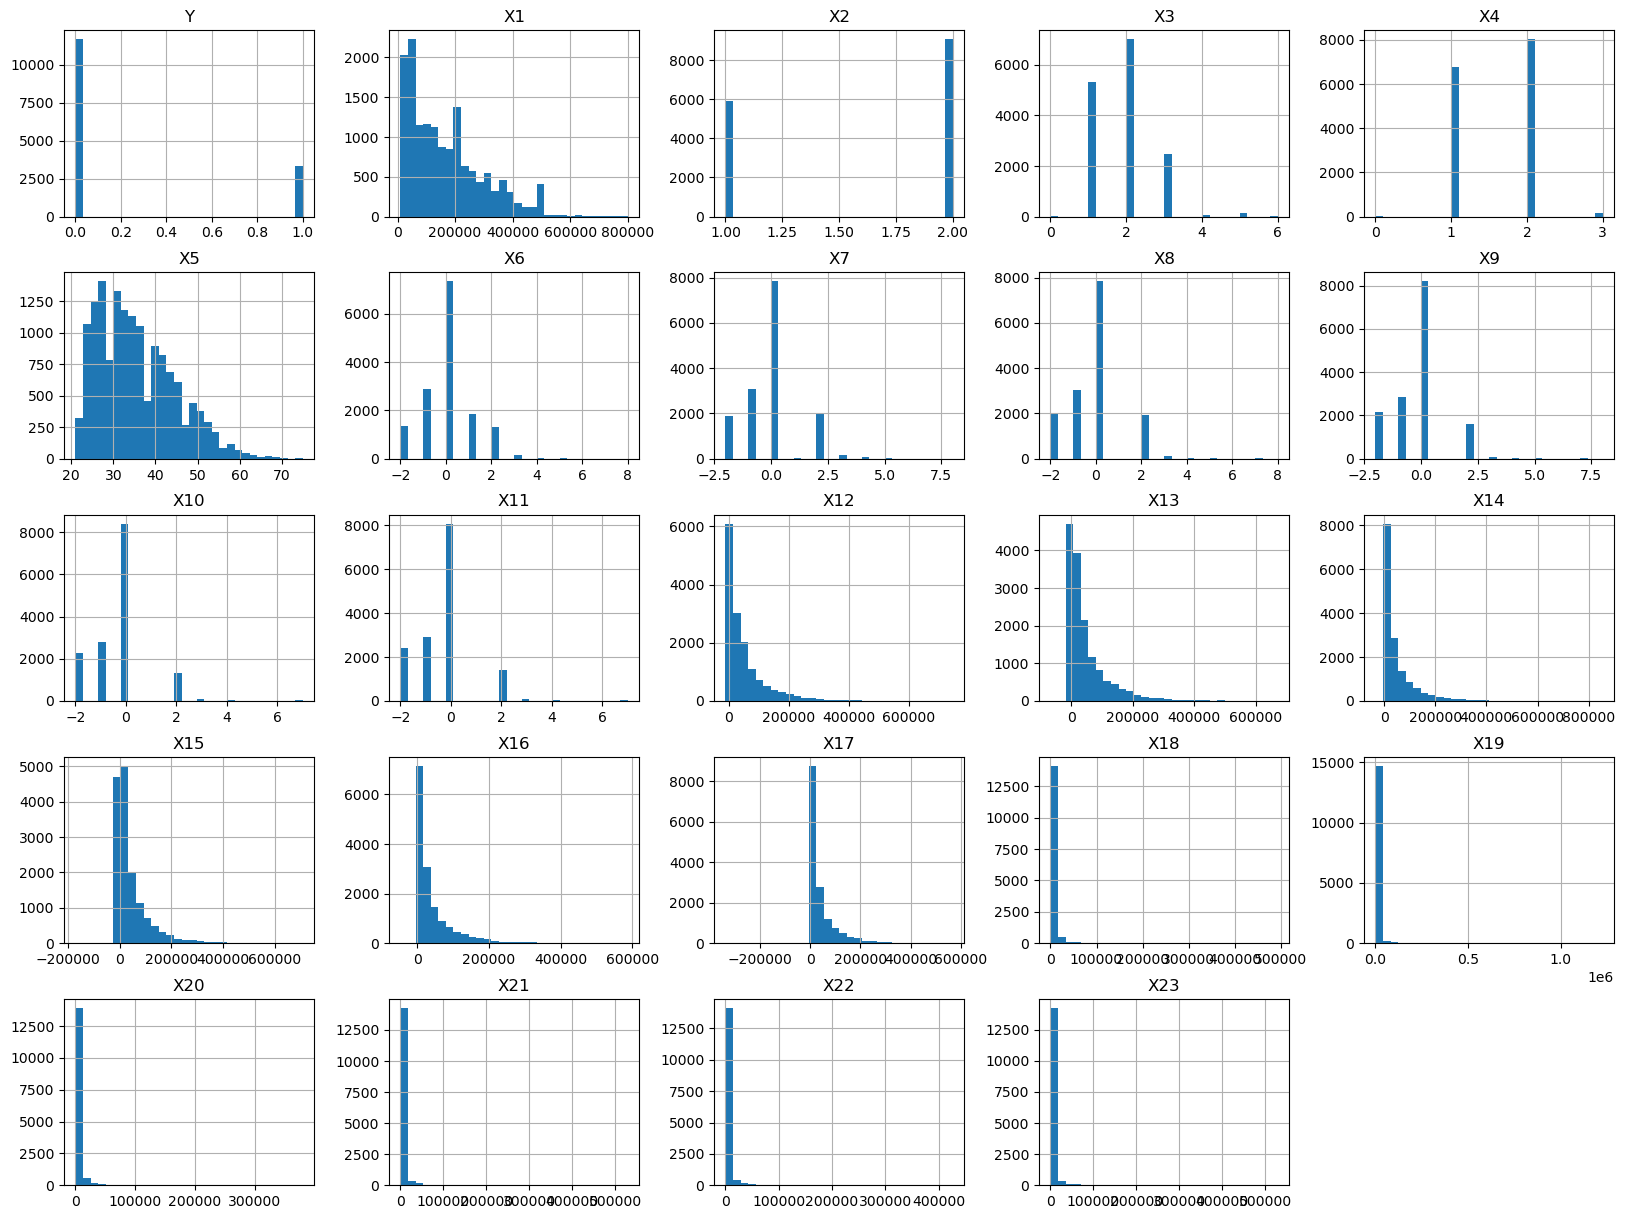

In [6]:
# Check distributions of columns
train_data.hist(bins=30, figsize=(20, 15))
plt.show()

### **Investigating whether the categorical features contain unexpected or undocumented values.**

In [7]:
# List of categorical features to check
categorical_features = ["X2", "X3", "X4", "X6", "X7", "X8", "X9", "X10", "X11"]

# Clean print version (text output)
print("Categorical Feature Frequencies (Train and Test)")

for feature in categorical_features:
    train_counts = train_data[feature].value_counts().sort_index()
    test_counts = test_data[feature].value_counts().sort_index()

    combined = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0).astype(int)
    print(f"\nFeature: {feature}")
    print(combined)


# Create a dictionary of value counts

# Train set
train_counts = {}
for feature in categorical_features:
    train_counts[feature] = train_data[feature].value_counts().sort_index()

train_df = pd.DataFrame(train_counts).fillna(0).astype(int)

# Display train frequency table
display(train_df.style.background_gradient(cmap='Blues').set_caption("Train Set - Frequency of Values per Categorical Feature"))
print()

# Test set
test_counts = {}
for feature in categorical_features:
    test_counts[feature] = test_data[feature].value_counts().sort_index()

test_df = pd.DataFrame(test_counts).fillna(0).astype(int)

# Display test frequency table
display(test_df.style.background_gradient(cmap='Greens').set_caption("Test Set - Frequency of Values per Categorical Feature"))

Categorical Feature Frequencies (Train and Test)

Feature: X2
    Train  Test
X2             
1    5927  5961
2    9073  9039

Feature: X3
    Train  Test
X3             
0       3    11
1    5312  5273
2    7015  7015
3    2458  2459
4      56    67
5     126   154
6      30    21

Feature: X4
    Train  Test
X4             
0      28    26
1    6771  6888
2    8031  7933
3     170   153

Feature: X6
    Train  Test
X6             
-2   1370  1389
-1   2901  2785
 0   7334  7403
 1   1844  1844
 2   1322  1345
 3    150   172
 4     42    34
 5     16    10
 6      6     5
 7      8     1
 8      7    12

Feature: X7
    Train  Test
X7             
-2   1870  1912
-1   3059  2991
 0   7834  7896
 1     20     8
 2   1977  1950
 3    155   171
 4     56    43
 5     11    14
 6     10     2
 7      7    13
 8      1     0

Feature: X8
    Train  Test
X8             
-2   2021  2064
-1   3021  2917
 0   7833  7931
 1      3     1
 2   1921  1898
 3    118   122
 4     40    36
 5     17

,X2,X3,X4,X6,X7,X8,X9,X10,X11
-2,0,0,0,1370,1870,2021,2169,2270,2423
-1,0,0,0,2901,3059,3021,2853,2784,2911
0,0,3,28,7334,7834,7833,8195,8408,8083
1,5927,5312,6771,1844,20,3,1,0,0
2,9073,7015,8031,1322,1977,1921,1592,1341,1418
3,0,2458,170,150,155,118,94,106,93
4,0,56,0,42,56,40,42,49,27
5,0,126,0,16,11,17,19,8,8
6,0,30,0,6,10,9,2,4,14
7,0,0,0,8,7,16,32,30,23


,X2,X3,X4,X6,X7,X8,X9,X10,X11
-2,0,0,0,1389,1912,2064,2179,2276,2472
-1,0,0,0,2785,2991,2917,2834,2755,2829
0,0,11,26,7403,7896,7931,8260,8539,8203
1,5961,5273,6888,1844,8,1,1,0,0
2,9039,7015,7933,1345,1950,1898,1567,1285,1348
3,0,2459,153,172,171,122,86,72,91
4,0,67,0,34,43,36,27,35,22
5,0,154,0,10,14,4,16,9,5
6,0,21,0,5,2,14,3,0,5
7,0,0,0,1,13,11,26,28,23


#### **Undocumented / Unexpected Values**
These features contain values outside the documented range:
- `X3` (Education) includes unexpected values **0**, **5** and **6**.
- `X4` (Marital Status) includes value **0**.
- `X6` - `X11`(Payment History) include a considerable amount of values **-2** and **0**.

The original metadata does not provide any explanation for these values. A more in-depth analysis is necessary to assess their potential impact on the performance of the classification models.

Y      1.000000
X6     0.331649
X7     0.268786
X8     0.234252
X9     0.221039
X10    0.211088
X11    0.192512
X3     0.038325
X5     0.011005
X17   -0.001679
X16   -0.003687
X15   -0.005166
X14   -0.010390
X13   -0.010794
X12   -0.018290
X4    -0.024420
X2    -0.038752
X23   -0.053284
X22   -0.054227
X21   -0.056760
X19   -0.063889
X20   -0.069627
X18   -0.074303
X1    -0.159296
Name: Y, dtype: float64


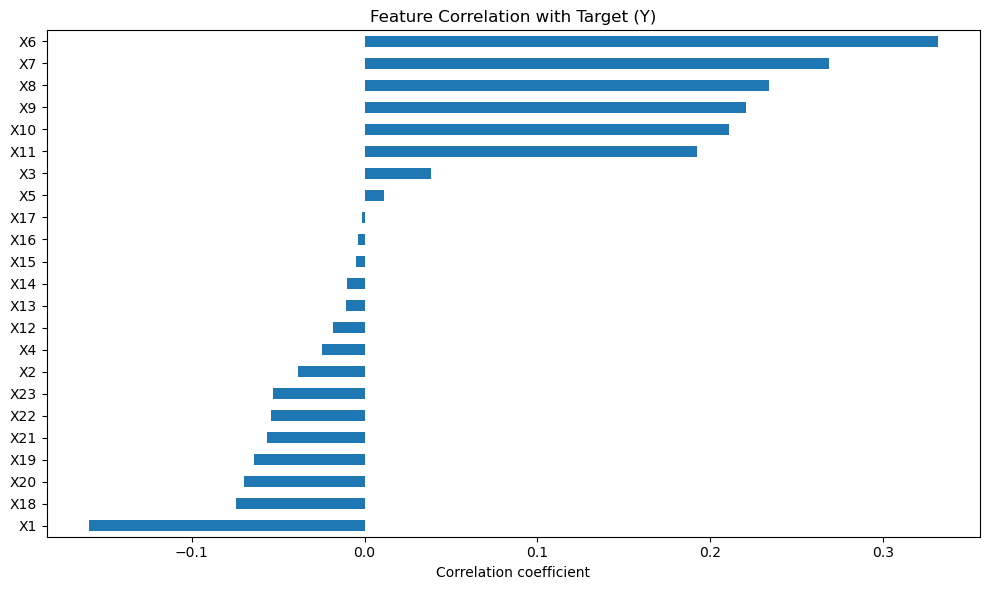

In [8]:
# Get correlation with Y only
correlation_with_target = train_data.corr(numeric_only=True)['Y'].sort_values(ascending=False)
print(correlation_with_target)

correlation_with_target.drop('Y').sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Correlation with Target (Y)")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

To check the relevance of features with undocumented values, I computed the correlation between each feature and the target variable (`Y`):

- `X6` to `X11` show the strongest positive correlations with default (`Y`), supporting their importance even with unexplained values.

- `X3` and `X4` have very weak correlations with the target, indicating low individual predictive power, though they may still contribute in interaction with others.

### **Class Distribution in Training Set**

Class Distribution (Train):
Y
0    11682
1     3318
Name: count, dtype: int64


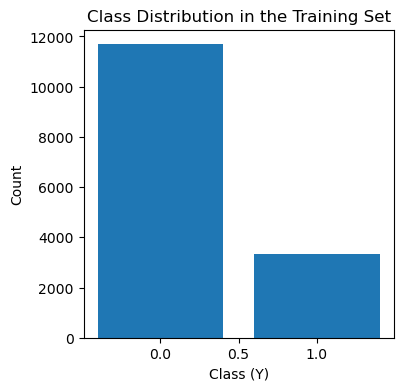

In [9]:
# Class Distribution in Training Set 
print("Class Distribution (Train):")
class_counts = train_data['Y'].value_counts()
print(class_counts)

plt.figure(figsize=(4, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class (Y)')
plt.ylabel('Count')
plt.title('Class Distribution in the Training Set')
plt.show()

The distribution shows an **imbalanced** training set, where roughly 78% of the instances are non-default and only 22% are defaults. An imbalance this high can significantly affect model training because most algorithms tend to favor the majority class, leading to poor recall and F1 scores for the minority class (defaults). 

Because the dataset is imbalanced, I use **F1-score as the primary evaluation metric** for:

- Hyperparameter tuning (`scoring="f1"` in cross-validation), and  
- Comparing the final tuned models on the test set.

Accuracy is still reported for context, but it is **not** used to choose the best model, since a high
accuracy can be misleading when 78% of samples belong to the majority class (non-default).





<br>

---
<br>

### **Features Separation**

In [10]:
# Separate features and labels
X_train = train_data.drop(columns=["Y"])
y_train = train_data["Y"]

X_test = test_data.drop(columns=["Y"])
y_test = test_data["Y"]

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)



X_train shape: (15000, 23)
y_train shape: (15000,)
X_test shape:  (15000, 23)
y_test shape:  (15000,)


<br>

---

# **Tuning and Evaluating Predictive Models**

### Evaluation Protocol

The dataset for this workflow came with a predefined split into a training set and a test set (`creditdefault_train.csv` and `creditdefault_test.csv`).

In this notebook:

- I use **cross-validation on the training set** to tune hyperparameters for each model  
  (k-NN, Random Forest, AdaBoost), primarily using **F1-score** because of class imbalance.
- I then evaluate each tuned model on the **same held-out test set** to compare their performance  
  (Accuracy, Precision, Recall, F1, AUC) and to run threshold analysis.

In a production or competition setting, a stricter protocol would be:

- Use cross-validation (or an additional validation split) on the training data for model selection, and  
- Reserve a final **test set that is touched only once** at the very end.

Because this is a workflow setting with a fixed train–test split, I follow the simpler
train-CV–test workflow, but I am aware of the difference and its implications for generalisation.

# **k-NN Model**

### **Feature Transformation for k-NN**
- Because k-NN is a distance-based algorithm, features with large numerical values (e.g., X1: Credit Amount in NT dollars) will dominate features with smaller values (e.g., X5: Age), thus numerical features need to be scaled (StandardScaler).
- Categorical variables (X2, X4) need to be encoded, since k-NN cannot directly work with non-numeric values.
- Other integer-coded variables (e.g., X3, X6–X11) are left as ordinal numeric features, since their codes already represent ordered categories and can be meaningfully used in distance calculations after scaling.

In [11]:
# Create copies for k-NN processing (preserving original dataset for other models)
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

# One-hot encode X2 (Gender) and X4 (Marital Status)
X_train_knn = pd.get_dummies(X_train_knn, columns=["X2", "X4"], drop_first=True)
X_test_knn = pd.get_dummies(X_test_knn, columns=["X2", "X4"], drop_first=True)


# Print new shapes to verify encoding
print("X_train_knn shape after encoding:", X_train_knn.shape)
print("X_test_knn shape after encoding:", X_test_knn.shape)

print("\nFirst 5 rows of the training data (for k-NN):")
encoded = pd.DataFrame(X_train_knn, columns=X_train_knn.columns).head()
display(encoded)


X_train_knn shape after encoding: (15000, 25)
X_test_knn shape after encoding: (15000, 25)

First 5 rows of the training data (for k-NN):


,X1,X3,X5,X6,X7,X8,X9,X10,X11,X12,...,X18,X19,X20,X21,X22,X23,X2_2,X4_1,X4_2,X4_3
0,20000,2,24,2,2,-1,-1,-2,-2,3913,...,0,689,0,0,0,0,True,True,False,False
1,50000,2,37,0,0,0,0,0,0,46990,...,2000,2019,1200,1100,1069,1000,True,True,False,False
2,50000,2,57,-1,0,-1,0,0,0,8617,...,2000,36681,10000,9000,689,679,False,True,False,False
3,50000,1,37,0,0,0,0,0,0,64400,...,2500,1815,657,1000,1000,800,False,False,True,False
4,500000,1,29,0,0,0,0,0,0,367965,...,55000,40000,38000,20239,13750,13770,False,False,True,False


In [12]:
# Identify columns to scale (excluding newly created binary features)
columns_to_scale = [col for col in X_train_knn.columns if col not in ["X2_2", "X4_1", "X4_2", "X4_3"]]  

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling on selected columns
X_train_knn[columns_to_scale] = scaler.fit_transform(X_train_knn[columns_to_scale])
X_test_knn[columns_to_scale] = scaler.transform(X_test_knn[columns_to_scale])

# Preview a snippet of the scaled training set
print("\nFirst 5 rows of the scaled training data (for k-NN):")
scaled_preview = pd.DataFrame(X_train_knn, columns=X_train_knn.columns).head()
display(scaled_preview)


First 5 rows of the scaled training data (for k-NN):


,X1,X3,X5,X6,X7,X8,X9,X10,X11,X12,...,X18,X19,X20,X21,X22,X23,X2_2,X4_1,X4_2,X4_3
0,-1.133312,0.190680,-1.241880,1.795954,1.778132,-0.696012,-0.665403,-1.517537,-1.480405,-0.648326,...,-0.361127,-0.238126,-0.362691,-0.302890,-0.310311,-0.288765,True,True,False,False
1,-0.902730,0.190680,0.178294,0.018192,0.109256,0.135544,0.181669,0.223690,0.244272,-0.063172,...,-0.232520,-0.176427,-0.274640,-0.236219,-0.241180,-0.233514,True,True,False,False
2,-0.902730,0.190680,2.363176,-0.870688,0.109256,-0.696012,0.181669,0.223690,0.244272,-0.584428,...,-0.232520,1.431569,0.371061,0.242604,-0.265755,-0.251249,False,True,False,False
3,-0.902730,-1.080518,0.178294,0.018192,0.109256,0.135544,0.181669,0.223690,0.244272,0.173324,...,-0.200368,-0.185890,-0.314483,-0.242280,-0.245643,-0.244564,False,False,True,False
4,2.555999,-1.080518,-0.695659,0.018192,0.109256,0.135544,0.181669,0.223690,0.244272,4.296924,...,3.175580,1.585540,2.425567,0.923805,0.578883,0.472041,False,False,True,False


### **k-NN Hyperparameter Tuning with Cross-Validation**

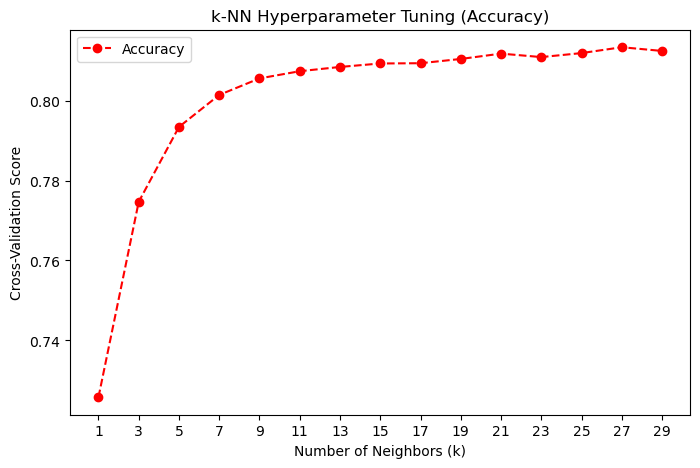

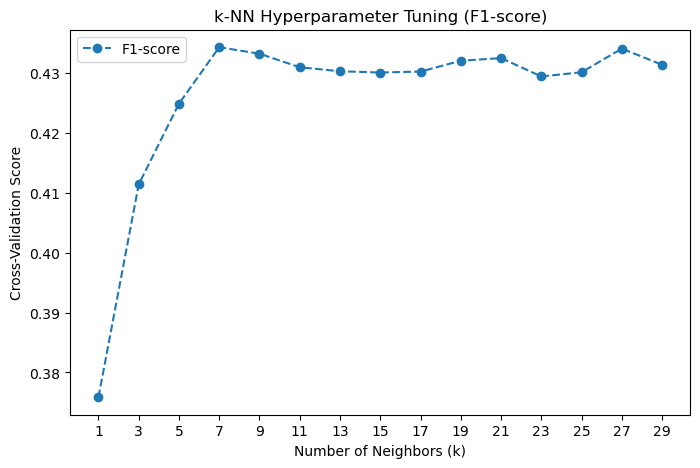

Optimal k found (based on F1-score): 7


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Choosing k values to test
k_values = list(range(1, 30, 2))  # Checking k from 1 to 29 (odd numbers)
cv_f1_scores = [] 
cv_accuracy_scores = [] 

# Perform cross-validation for different k values using both accuracy and F1-score
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # F1-score
    f1_scores = cross_val_score(knn, X_train_knn, y_train, cv=5, scoring='f1')
    cv_f1_scores.append(f1_scores.mean())

    # Accuracy
    acc_scores = cross_val_score(knn, X_train_knn, y_train, cv=5, scoring='accuracy')
    cv_accuracy_scores.append(acc_scores.mean())

# Plot Accuracy vs k-values
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_accuracy_scores, marker='o', linestyle='dashed', color="red", label="Accuracy")
plt.xticks(k_values)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Score")
plt.title("k-NN Hyperparameter Tuning (Accuracy)")
plt.legend()
plt.show()

# Plot F1-score vs k-values
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_f1_scores, marker='o', linestyle='dashed', label="F1-score")
plt.xticks(k_values)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Score")
plt.title("k-NN Hyperparameter Tuning (F1-score)")
plt.legend()
plt.show()


# Select the best k value based on F1-score (for balanced evaluation)
best_k = k_values[np.argmax(cv_f1_scores)]
print(f"Optimal k found (based on F1-score): {best_k}")




### **k-NN Final Model and Test Set Evaluation**



Final Test Set Evaluation (k-NN):
k-NN Accuracy : 0.8037
k-NN Precision: 0.5989
k-NN Recall   : 0.3412
k-NN F1 Score : 0.4347
k-NN AUC Score: 0.7159


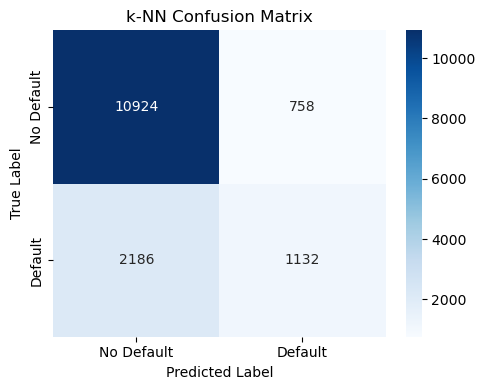

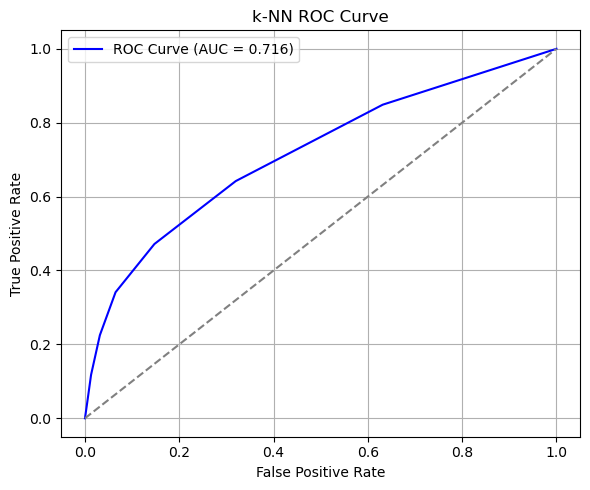

In [14]:
# Train final k-NN model with the best k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_knn, y_train)

# Predictions on test data
y_pred_knn = knn_best.predict(X_test_knn)
y_proba_knn = knn_best.predict_proba(X_test_knn)[:, 1]

# Evaluate performance
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, y_proba_knn)

# Print evaluation metrics
print("\nFinal Test Set Evaluation (k-NN):")
print(f"k-NN Accuracy : {knn_accuracy:.4f}")
print(f"k-NN Precision: {knn_precision:.4f}")
print(f"k-NN Recall   : {knn_recall:.4f}")
print(f"k-NN F1 Score : {knn_f1:.4f}")
print(f"k-NN AUC Score: {knn_auc:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("k-NN Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)

plt.figure(figsize=(6, 5))
plt.plot(fpr_knn, tpr_knn, label=f"ROC Curve (AUC = {knn_auc:.3f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("k-NN ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

---


# **Random Forest Model**

### **Hyperparameter Tuning with Cross-Validation**

To build an effective Random Forest model, a two-stage tuning approach was used:

1. **Broad Search:**  
An iterative approach was performed, where a broad search over many hyperparameter values identified regions where the model performed well.

3. **Narrowed Grid Search (Shown Below):**  
   Based on performance patterns observed in the broader searches, a more focused search was conducted around the top-performing combinations.  
   The results below reflect the best model found in this refined search.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Final hyperparameter grid
param_grid = {
    'n_estimators': [130, 145, 160],
    'max_depth': [6, 8, 10],
    'max_features': ['sqrt'],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced_subsample', 'balanced'] # Addresses class imbalance
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV with F1-score and 5-fold CV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample', 'balanced'],
                         'max_depth': [6, 8, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [130, 145, 160]},
             scoring='f1', verbose=1)

In [16]:
# Best hyperparameters and score
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validated F1-score: {grid_search.best_score_:.4f}")

Best Hyperparameters:
{'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 145}

Best Cross-Validated F1-score: 0.5492


### **The impact of varying one hyperparameter (n_estimators) on Random Forest Model Accuracy and F1-Score**

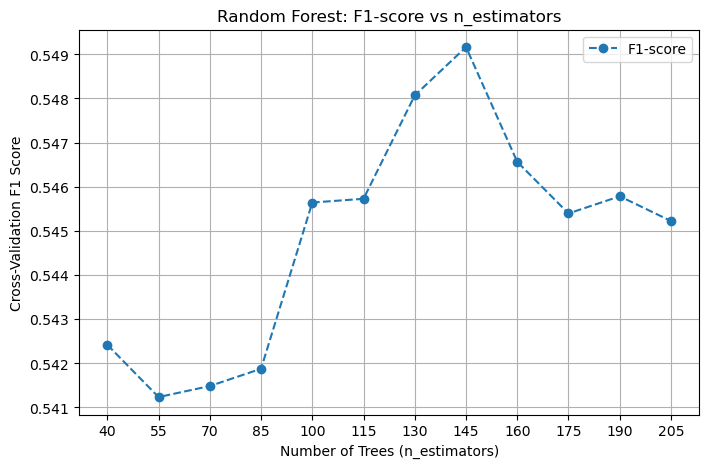

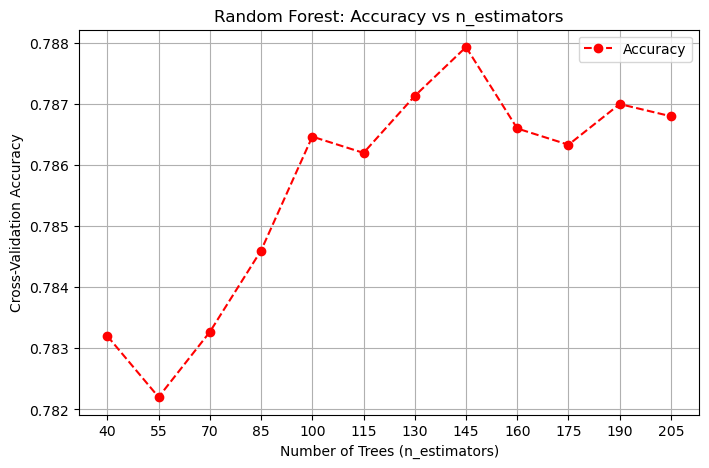

In [17]:
# Range of n_estimators to test
n_estimators_values = list(range(40, 211, 15))  # Testing n_estimators from 40 to 210 in steps of 15
f1_scores = []
accuracy_scores = []

# Prepare fixed parameters (all best parameters except n_estimators)
fixed_params = grid_search.best_params_.copy()
fixed_params.pop('n_estimators', None)


for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, **fixed_params)
    
    f1 = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    acc = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    f1_scores.append(f1)
    accuracy_scores.append(acc)


# Plot F1-score vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_values, f1_scores, marker='o', linestyle='--', label="F1-score")
plt.xticks(n_estimators_values)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross-Validation F1 Score")
plt.title("Random Forest: F1-score vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()


# Plot Accuracy vs n_estimators
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_values, accuracy_scores, marker='o', linestyle='--', color='red', label="Accuracy")
plt.xticks(n_estimators_values)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Random Forest: Accuracy vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()

The charts above illustrate how the accuracy and F1-score of the Random Forest model change as the numeric hyperparameter, n_estimators, increases while keeping all other parameters fixed at their optimal values. The accuracy and F1-score improve up to a certain point (145 trees), after which they decline.

### **Random Forest Final Model and Test Set Evaluation**



Final Test Set Evaluation (Random Forest):
Accuracy : 0.7860
Precision: 0.5143
Recall   : 0.5856
F1 Score : 0.5476
AUC Score: 0.7775


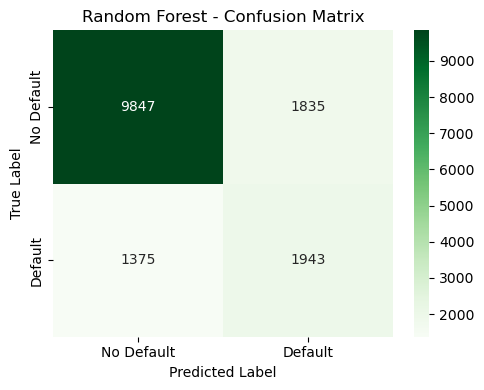

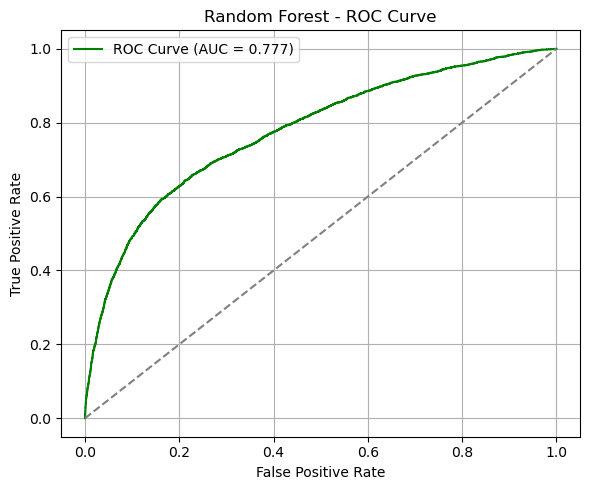

In [18]:
# Final model and predictions
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1] 

# Evaluation on test set
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print("\nFinal Test Set Evaluation (Random Forest):")
print(f"Accuracy : {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall   : {rf_recall:.4f}")
print(f"F1 Score : {rf_f1:.4f}")
print(f"AUC Score: {rf_auc:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {rf_auc:.3f})", color="green")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<br>

---



# **AdaBoost Model**
### **Hyperparameter Tuning with Cross-Validation**


In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid
param_grid_ada = {
    'n_estimators': [5, 10, 20, 40, 60, 80, 100, 125, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
    'estimator__max_depth': [1, 2, 3], 
    'algorithm': ['SAMME'] 
}

# The base estimator to tune
base_clf = DecisionTreeClassifier(random_state=42)

# Initialize AdaBoost model
ada = AdaBoostClassifier(estimator=base_clf, algorithm='SAMME', random_state=42)

# Set up GridSearchCV with F1 scoring
grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search_ada.fit(X_train, y_train)

# Best params and score
print("\n Best Parameters:", grid_search_ada.best_params_)
print(f" Best CV F1 Score: {grid_search_ada.best_score_:.4f}")


Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 Best Parameters: {'algorithm': 'SAMME', 'estimator__max_depth': 1, 'learning_rate': 0.2, 'n_estimators': 5}
 Best CV F1 Score: 0.4836


### **The impact of varying one hyperparameter (n_estimators) on AdaBoost Model Accuracy and F1-Score**
This illustrates how the model's accuracy and F1-score change as the numeric hyperparameter, n_estimators, varies while keeping all other parameters fixed at their optimal values.

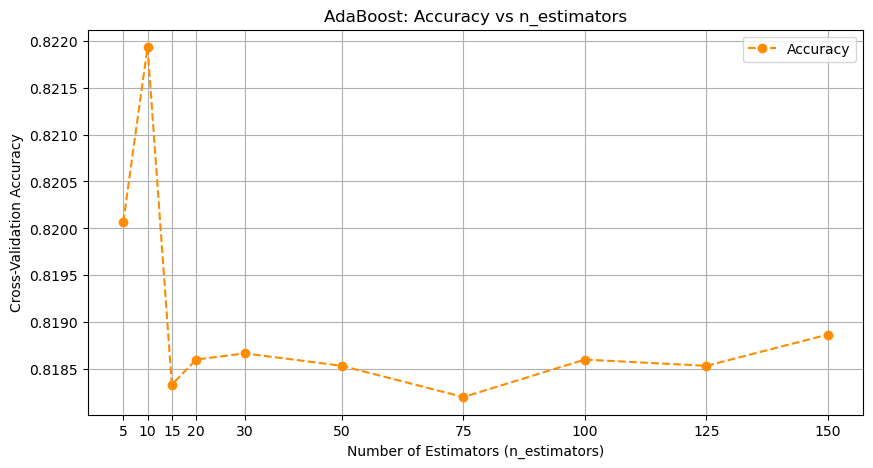

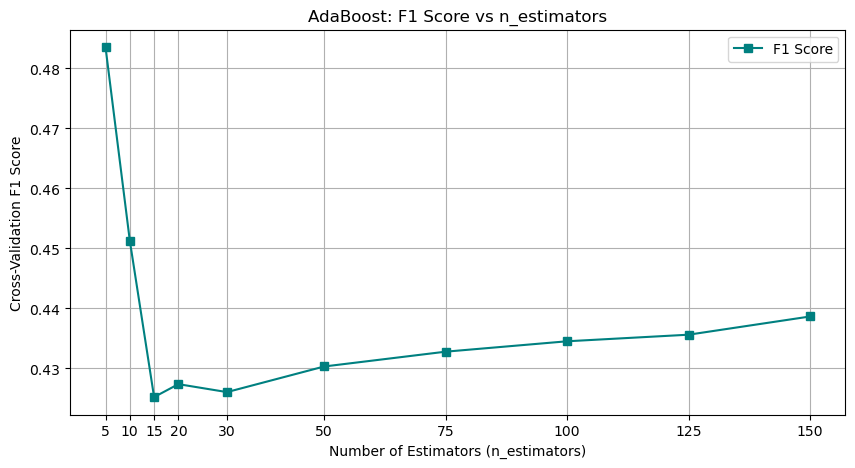

In [20]:
# Range of n_estimators to test
n_estimators_values = [5, 10, 15, 20, 30, 50, 75, 100, 125, 150]
accuracy_scores = []
f1_scores = []

# Get the best parameters from grid search and remove 'n_estimators'
fixed_params = grid_search_ada.best_params_.copy()
fixed_params.pop('n_estimators', None)
# fixed_params now contains: 'learning_rate', 'estimator__max_depth', and 'algorithm'

for n in n_estimators_values:
    base_estimator = DecisionTreeClassifier(max_depth=fixed_params['estimator__max_depth'], random_state=42)
    ada_model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n,
        learning_rate=fixed_params['learning_rate'],
        algorithm=fixed_params['algorithm'],
        random_state=42
    )
    
    # Cross-validate for accuracy and F1
    acc = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    f1 = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)


# Plot Accuracy vs. n_estimators
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, accuracy_scores, marker='o', linestyle='--', color='darkorange', label="Accuracy")
plt.xticks(n_estimators_values)
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("AdaBoost: Accuracy vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()


# Plot F1 Score vs. n_estimators
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, f1_scores, marker='s', linestyle='-', color='teal', label="F1 Score")
plt.xticks(n_estimators_values)
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Cross-Validation F1 Score")
plt.title("AdaBoost: F1 Score vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()

Accuracy remains fairly stable across all values (81.8%–82.2%), with a slight peak at 10 estimators (82.2%). The F1 Score is highest at 5 estimators and consistently lower at higher values, indicating that a smaller number of estimators helped AdaBoost better balance precision and recall for this imbalanced dataset.

### **AdaBoost Final Model and Test Set Evaluation**


Final Evaluation on Test Set (AdaBoost):
Accuracy : 0.8194
Precision: 0.6631
Recall   : 0.3731
F1 Score : 0.4775
AUC Score: 0.7208


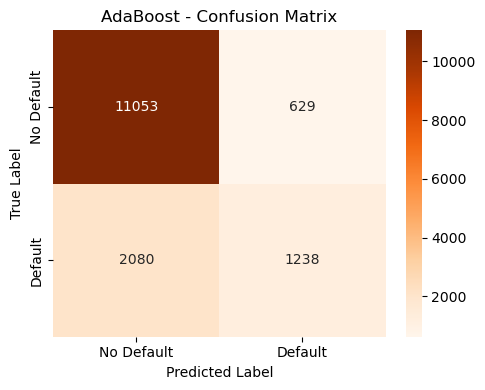

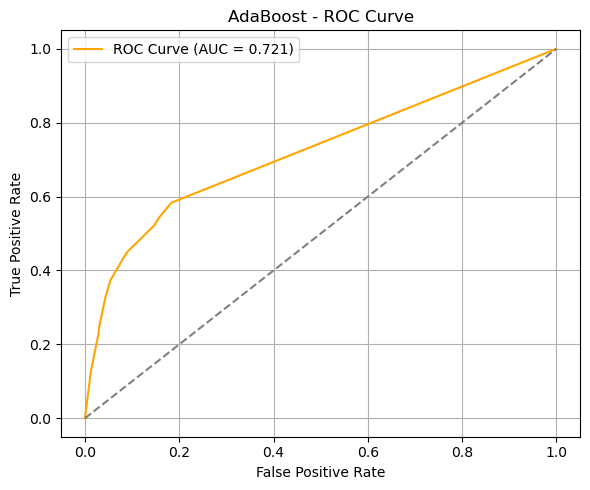

In [21]:
# Final model and prediction on test set
best_ada_model = grid_search_ada.best_estimator_
y_pred_ada = best_ada_model.predict(X_test)
y_proba_ada = best_ada_model.predict_proba(X_test)[:, 1] 

# Evaluation on test set
ada_accuracy = accuracy_score(y_test, y_pred_ada)
ada_precision = precision_score(y_test, y_pred_ada)
ada_recall = recall_score(y_test, y_pred_ada)
ada_f1 = f1_score(y_test, y_pred_ada)
ada_auc = roc_auc_score(y_test, y_proba_ada)

# Final test set evaluation
print("\nFinal Evaluation on Test Set (AdaBoost):")
print(f"Accuracy : {ada_accuracy:.4f}")
print(f"Precision: {ada_precision:.4f}")
print(f"Recall   : {ada_recall:.4f}")
print(f"F1 Score : {ada_f1:.4f}")
print(f"AUC Score: {ada_auc:.4f}")

# Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AdaBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_proba_ada)

plt.figure(figsize=(6, 5))
plt.plot(fpr_ada, tpr_ada, label=f"ROC Curve (AUC = {ada_auc:.3f})", color="orange")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AdaBoost - ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<br>

---
   
    
   
## **Model Performance Comparison**

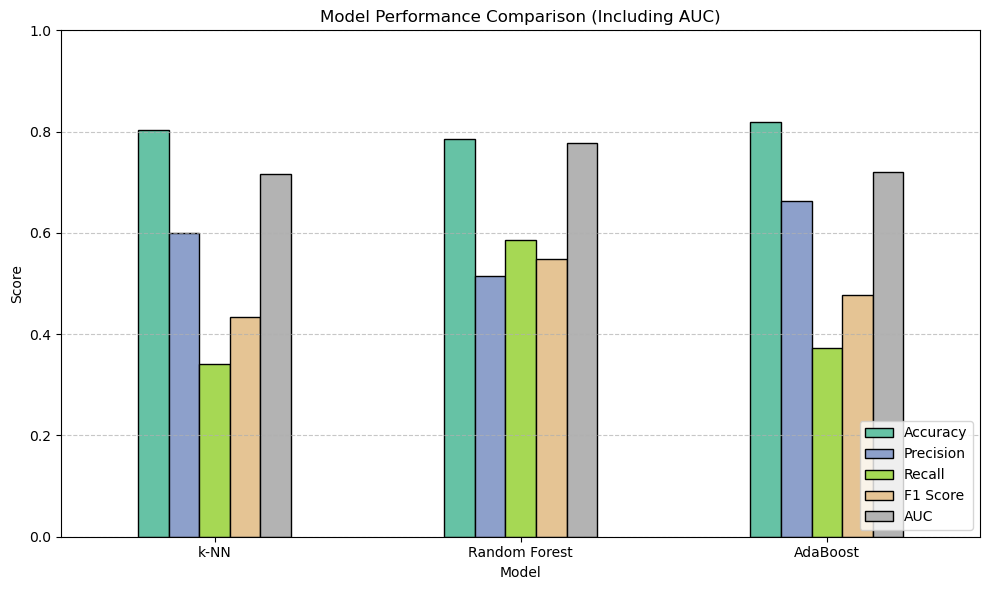

In [22]:
# Create a DataFrame with all performance metrics including AUC
model_metrics = pd.DataFrame({
    'Model': ['k-NN', 'Random Forest', 'AdaBoost'],
    'Accuracy': [knn_accuracy, rf_accuracy, ada_accuracy],
    'Precision': [knn_precision, rf_precision, ada_precision],
    'Recall': [knn_recall, rf_recall, ada_recall],
    'F1 Score': [knn_f1, rf_f1, ada_f1],
    'AUC': [knn_auc, rf_auc, ada_auc]
})

# Set 'Model' as index for plotting
model_metrics.set_index('Model', inplace=True)

# Plot the comparison
model_metrics.plot(kind='bar', figsize=(10, 6), colormap='Set2', edgecolor='black')

plt.title("Model Performance Comparison (Including AUC)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

When evaluating the three models (k-NN, Random Forest, and AdaBoost) the F1-score was selected as the primary metric. This choice was driven by two key factors:
- the dataset is highly imbalanced, with non-defaulting clients forming nearly 78% of the data.
- the task involves financial risk prediction, where both false positives (predicting default when there isn’t one) and false negatives (failing to catch a true defaulter) carry important consequences.
In such settings, F1-score (supported with Recall and AUC) provides a more meaningful measure than accuracy by combining both precision (how many predicted defaulters were actually correct) and recall (how many actual defaulters were correctly identified), which is critical for balancing risk exposure and customer experience in  credit systems.

Based on test set results:

- Random Forest delivered the strongest performance overall, achieving the highest F1 score (0.5476) and a solid AUC (0.7775), indicating good discriminatory ability alongside balanced precision and recall.

- AdaBoost followed with a lower F1 score (0.4775), but the highest precision (0.6631). Its AUC (0.7208) was slightly higher than k-NN, reflecting its cautious approach in predicting defaults.

- k-NN, despite having the highest accuracy (0.8037), showed the lowest recall (0.3412) and F1 score (0.4347). Its AUC (0.7159) was comparable to AdaBoost but reflected limited effectiveness in identifying true defaulters.

## **Optimal threshold tuning (probability threshold) for the classification models** 

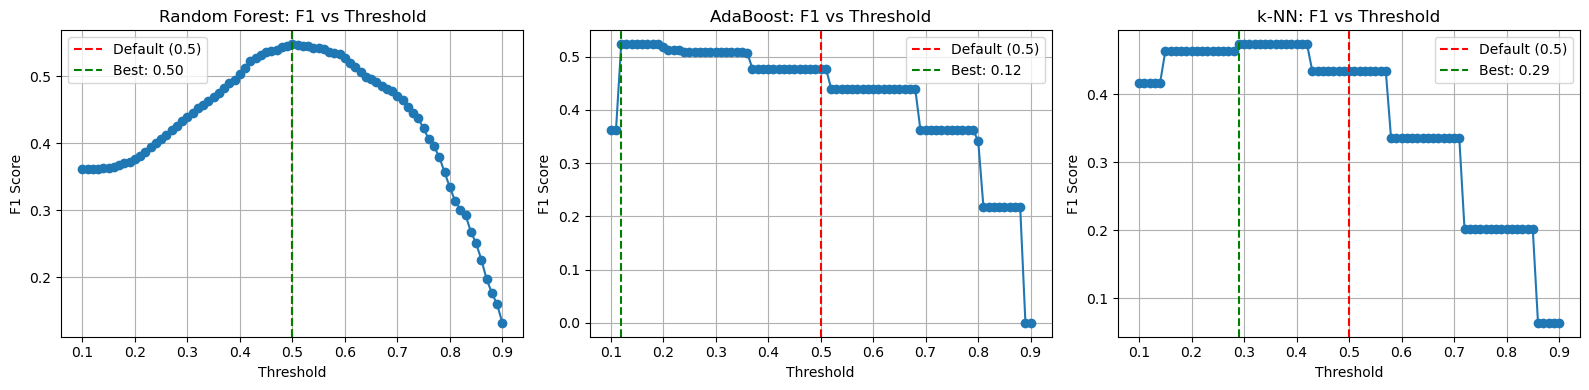


Optimal Threshold Summary
Random Forest: Threshold = 0.50, Best F1 Score = 0.5476
AdaBoost: Threshold = 0.12, Best F1 Score = 0.5235
k-NN: Threshold = 0.29, Best F1 Score = 0.4740


In [23]:
# Models and their names
models = {
    "Random Forest": (best_rf_model, X_test),
    "AdaBoost": (best_ada_model, X_test),
    "k-NN": (knn_best, X_test_knn)
}

# Prepare figure
plt.figure(figsize=(16, 4))
thresholds = np.arange(0.1, 0.91, 0.01)

# Track optimal thresholds and F1s
threshold_summary = {}

for i, (name, (model, X)) in enumerate(models.items(), 1):
    y_proba = model.predict_proba(X)[:, 1]
    f1_scores = []

    for t in thresholds:
        y_pred_thresh = (y_proba >= t).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh))

    best_t = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    threshold_summary[name] = (best_t, best_f1)

    # Plotting
    plt.subplot(1, 3, i)
    plt.plot(thresholds, f1_scores, marker='o')
    plt.axvline(0.5, color='red', linestyle='--', label='Default (0.5)')
    plt.axvline(best_t, color='green', linestyle='--', label=f'Best: {best_t:.2f}')
    plt.title(f"{name}: F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nOptimal Threshold Summary")
for model, (t, f1) in threshold_summary.items():
    print(f"{model}: Threshold = {t:.2f}, Best F1 Score = {f1:.4f}")


To improve classification performance on the imbalanced dataset, optimal thresholds were explored for each model. While Random Forest performed best at the default threshold of 0.50, both AdaBoost and k-NN showed improved F1 scores at lower thresholds (0.12 and 0.29 respectively), indicating their tendency to underpredict the minority class by default. Adjusting the threshold helped balance precision and recall, especially for AdaBoost.

 ### **Feature Importance and the Role of Undocumented Values in Random Forest Performance**

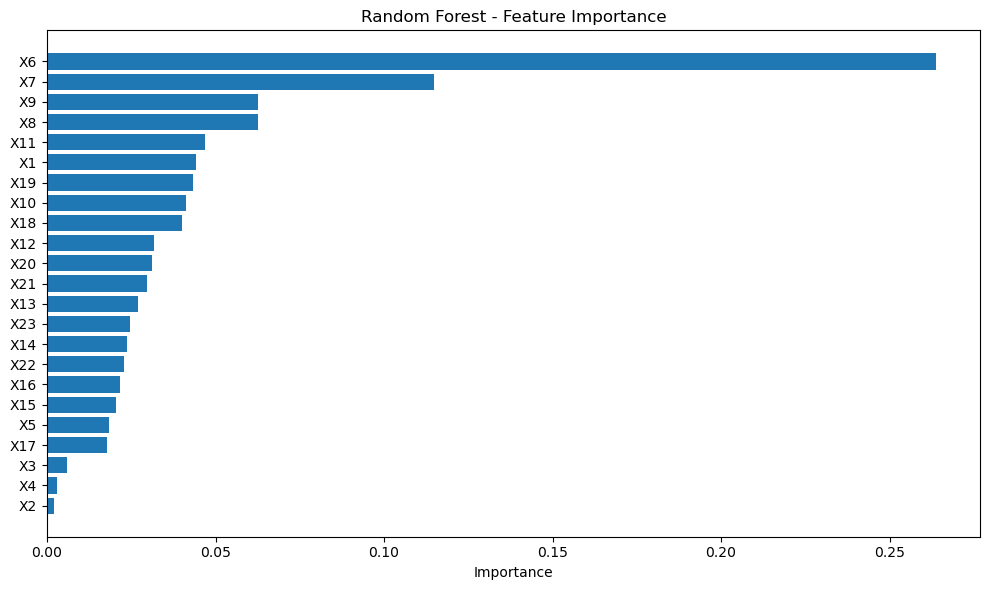

In [24]:
importances_rf = best_rf_model.feature_importances_
features_rf = X_train.columns

rf_importance_df = pd.DataFrame({
    'Feature': features_rf,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Random Forest - Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Several categorical features in the dataset,  `X3` (Education), `X4` (Marital Status), and the payment history features `X6` to `X11`, contained undocumented or unexpected values such as 0, 5, 6, and -2, which were not part of the original feature documentation and lacked clear semantic meaning.

In the case of Random Forest, the model assigned substantial importance to many of these features. For example, `X6` alone contributed over 26% to the model’s decision-making, with `X7` to `X11` also ranking highly in importance. Notably, these features contained large proportions of undocumented values, particularly -2 and 0, which accounted for over 50% of the distribution in both the training and test sets.

Despite their ambiguity, Random Forest was able to extract useful patterns from the undocumented values, likely using them as split points to separate defaulters from non-defaulters. This shows how tree-based models can handle irregular or noisy data well.

Still, if values like -2 had a defined meaning, proper labeling or encoding might have improved both performance. The model’s reliance on such values raises concerns, especially if they reflect inconsistent inputs or unknown policies.